# 03 Visual search with k-NN

In [1]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors

In [2]:
# Some global variables
features_basepath = '/data/ml_course/04_Applied_Machine_Learning_2/11_Course_project/'
img_basepath = '/data/ml_course/04_Applied_Machine_Learning_2/11_Course_project/Swissroads_imgs/'

In [3]:
# Load data
def load_data(features_basepath, features_file, one_hot_encoding=False):
    with np.load(os.path.join(features_basepath, features_file), allow_pickle=False) as npz_file:
        data = dict(npz_file.items())
        
    X = data['data']
    if one_hot_encoding:
        y = data['labels']
    else:
        y = np.where(data['labels'] == 1)[1]
    names = data['names']
    filenames = data['filenames']
    
    return X, y, names, filenames 

In [4]:
X_tr, y_tr, names, fn_tr = load_data(features_basepath, 'Swissroads_train.npz', one_hot_encoding=True)
X_va, y_va, _, fn_va = load_data(features_basepath, 'Swissroads_valid.npz', one_hot_encoding=True)
X_te, y_te, _, fn_te = load_data(features_basepath, 'Swissroads_test.npz', one_hot_encoding=True)
print(X_tr.shape, y_tr.shape)
print(X_va.shape, y_va.shape)
print(X_te.shape, y_te.shape)

(280, 1280) (280, 6)
(139, 1280) (139, 6)
(50, 1280) (50, 6)


## K-NN classifier

In [5]:
X = np.append(X_tr, X_va, axis=0)
y = np.append(y_tr, y_va, axis=0)
print(X.shape, y.shape)

(419, 1280) (419, 6)


In [6]:
# Create 5 test folds
n_folds = 5
n_tr = y_tr.shape[0]
n_va = int(y_va.shape[0]/n_folds)
test_fold = np.zeros(y.shape[0])
test_fold[:n_tr] = -1

test_fold[n_tr:n_tr+n_va] = 0
test_fold[n_tr+n_va:n_tr+2*n_va] = 1
test_fold[n_tr+2*n_va:n_tr+3*n_va] = 2
test_fold[n_tr+3*n_va:n_tr+4*n_va] = 3
test_fold[n_tr+4*n_va:] = 4

# create five folds with the validation data
ps = PredefinedSplit(test_fold)
ps.get_n_splits()

5

In [7]:
# Create pipeline
knn_pipe = Pipeline([
    ('scaler', None),
    ('knn', KNeighborsClassifier())
])

k_values = np.r_[np.arange(1, 10), np.arange(10, 51, step=5)]
weights_functions = ['uniform', 'distance']
distance_types = [1, 2] # L1, L2 distances

# Define a grid of values
grid = {
    'knn__n_neighbors': k_values,
    'knn__weights': weights_functions,
    'knn__p': distance_types
}

grid_cv = GridSearchCV(knn_pipe, grid, cv=ps, return_train_score=True, verbose=True, n_jobs=-1)

# Fit estimator
grid_cv.fit(X, y)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   36.3s finished
/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  4,  4])),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', None), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'knn__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 15, 20, 25, 30, 35, 40, 45,
       50]), 'knn__weights': ['uniform', 'distance'], 'knn__p': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

In [8]:
# Collect results in a DataFrame
knn_results = pd.DataFrame({
    'K': grid_cv.cv_results_['param_knn__n_neighbors'],
    'weights': grid_cv.cv_results_['param_knn__weights'],
    'distance': grid_cv.cv_results_['param_knn__p'],
    'mean_tr': grid_cv.cv_results_['mean_train_score'],
    'mean_te': grid_cv.cv_results_['mean_test_score'],
    'std_te': grid_cv.cv_results_['std_test_score']
})

# Ten best combinations according to the mean test score
knn_results.sort_values(by='mean_te', ascending=False).head(10)

,K,weights,distance,mean_tr,mean_te,std_te
0,1,uniform,1,1.000000,0.928058,0.032888
5,2,distance,1,1.000000,0.928058,0.032888
1,1,distance,1,1.000000,0.928058,0.032888
2,1,uniform,2,1.000000,0.913669,0.027641
3,1,distance,2,1.000000,0.913669,0.027641
7,2,distance,2,1.000000,0.913669,0.027641
15,4,distance,2,1.000000,0.913669,0.060004
32,9,uniform,1,0.898259,0.906475,0.060323
33,9,distance,1,1.000000,0.906475,0.060323
8,3,uniform,1,0.942741,0.906475,0.058881


In [9]:
# Report test score
acc_KNN = 100*grid_cv.score(X_te, y_te)
print('Test accuracy: {:.2f}%'.format(acc_KNN))

Test accuracy: 94.00%


In [10]:
# Store result
df_acc = pd.DataFrame({'model': 'k-NN', 'test_accuracy': acc_KNN}, index=[0])
df_acc.to_csv('acc_k-NN.csv', index=False)

## 10 nearest neighbors

In [11]:
# select image from test dataset
ind_te = np.random.randint(0, fn_te.size)
img_te_path = os.path.join(img_basepath+'/test/', fn_te[ind_te])
img_te = Image.open(img_te_path)

print(img_te_path)
print('Image index:', ind_te)

/data/ml_course/04_Applied_Machine_Learning_2/11_Course_project/Swissroads_imgs//test/bike/bike-0100.png
Image index: 0


In [12]:
# Find 10 nearest neighbors in training data using best model
grid_cv.best_estimator_.fit(X_tr, y_tr)
dist_tr, ind_tr = grid_cv.best_estimator_.named_steps['knn'].kneighbors(X=X_te[ind_te, :].reshape(1, -1), n_neighbors=10)
print(dist_tr)
print(ind_tr)

[[200.48428179 213.07092667 215.85037925 222.64717719 235.80618923
  240.78301265 248.20373868 249.65606495 249.97847017 252.19629755]]
[[ 26  24 197  34 235 103 170 198  61 200]]


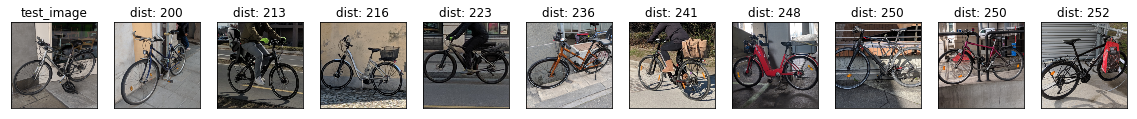

In [13]:
fig, axes = plt.subplots(ncols=11, nrows=1, figsize=(20, 2))
axes[0].imshow(img_te)
axes[0].set_title('test_image')
axes[0].set_xticks([])
axes[0].set_yticks([])

for i in range(10):
    img_tr_path = os.path.join(img_basepath+'/train/', fn_tr[ind_tr[0][i]])
    img_tr = Image.open(img_tr_path)
    axes[i+1].imshow(img_tr)
    axes[i+1].set_title('dist: {:.0f}'.format(dist_tr[0][i]))
    axes[i+1].set_xticks([])
    axes[i+1].set_yticks([])
plt.show()